1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

'wget' is not recognized as an internal or external command,
operable program or batch file.


1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [4]:
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight') 

In [5]:
N = 1310720
data = pd.read_csv('data/data_000637.txt', nrows = N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [6]:
data['BX_COUNTER_CHANGE'] = data['BX_COUNTER'].diff()
data.loc[data.BX_COUNTER_CHANGE >= -100, 'BX_COUNTER_CHANGE'] = 0
data.loc[data.BX_COUNTER_CHANGE < -100, 'BX_COUNTER_CHANGE'] = 1

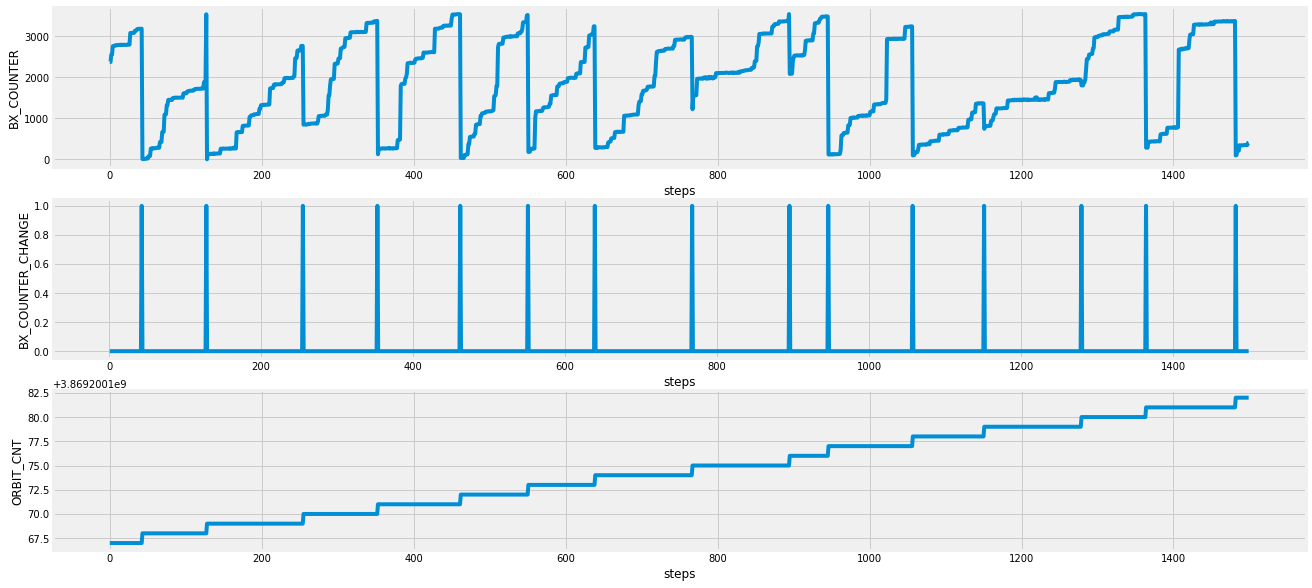

In [7]:
plt.figure(figsize = (20, 10))

plt.subplot(3, 1, 1)
plt.plot(data['BX_COUNTER'][0:1500])
plt.xlabel('steps')
plt.ylabel('BX_COUNTER')

plt.subplot(3, 1, 2)
plt.plot(data['BX_COUNTER_CHANGE'][0:1500])
plt.xlabel('steps')
plt.ylabel('BX_COUNTER_CHANGE')

plt.subplot(3, 1, 3)
plt.plot(data['ORBIT_CNT'][0:1500])
plt.xlabel('steps')
plt.ylabel('ORBIT_CNT')
plt.show()

In [8]:
X = data['BX_COUNTER'].max()
print( "x is :", X , "ns")

x is : 3563 ns


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [9]:
data['Time_ns'] = X*25* data['ORBIT_CNT'] + 25 *data['BX_COUNTER'] + (25/30) *data['TDC_MEAS']
data['Time_ns'] = pd.to_datetime(data['Time_ns'], unit='ns')
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,BX_COUNTER_CHANGE,Time_ns
0,1,0,123,3869200167,2374,26,NaN,1970-01-04 23:44:09.004934896
1,1,0,124,3869200167,2374,27,0.0,1970-01-04 23:44:09.004934897
2,1,0,63,3869200167,2553,28,0.0,1970-01-04 23:44:09.004939373
3,1,0,64,3869200167,2558,19,0.0,1970-01-04 23:44:09.004939490
4,1,0,64,3869200167,2760,25,0.0,1970-01-04 23:44:09.004944545
...,...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,0.0,1970-01-04 23:44:09.985075886
1310716,1,1,4,3869211171,763,11,0.0,1970-01-04 23:44:09.985075909
1310717,1,0,64,3869211171,764,0,0.0,1970-01-04 23:44:09.985075925
1310718,1,0,139,3869211171,769,0,0.0,1970-01-04 23:44:09.985076050


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [10]:
delta_t = data['Time_ns'].max() - data['Time_ns'].min()
print("delta_t =", delta_t)

delta_t = 0 days 00:00:00.980141154


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [11]:
data.groupby(['TDC_CHANNEL']).count().sort_values(by="HEAD", ascending=False)[:3]

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,BX_COUNTER_CHANGE,Time_ns
TDC_CHANNEL,,,,,,,
139,108059,108059,108059,108059,108059,108059,108059
64,66020,66020,66020,66020,66020,66020,66020
63,64642,64642,64642,64642,64642,64642,64642


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [12]:
no_empty_orbits= data.groupby("ORBIT_CNT").count()
print("The number of unique non-empty orbits (i.e. the number of orbits with at least one hit) is %d."%len(no_empty_orbits))

The number of unique non-empty orbits (i.e. the number of orbits with at least one hit) is 11001.


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [13]:
unique_orbits=pd.DataFrame(data[data['TDC_CHANNEL']==139]).drop_duplicates(subset=['ORBIT_CNT','BX_COUNTER'], inplace=False)
print("The number of unique orbits with at least one measurement from TDC_CHANNEL 139 is %d."%len(unique_orbits))

The number of unique orbits with at least one measurement from TDC_CHANNEL 139 is 107009.


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [14]:
FPGA_0 = pd.Series(data[data['FPGA']==0]['TDC_CHANNEL'].value_counts())
FPGA_1 = pd.Series(data[data['FPGA']==1]['TDC_CHANNEL'].value_counts())

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0, 0.5, 'Count')

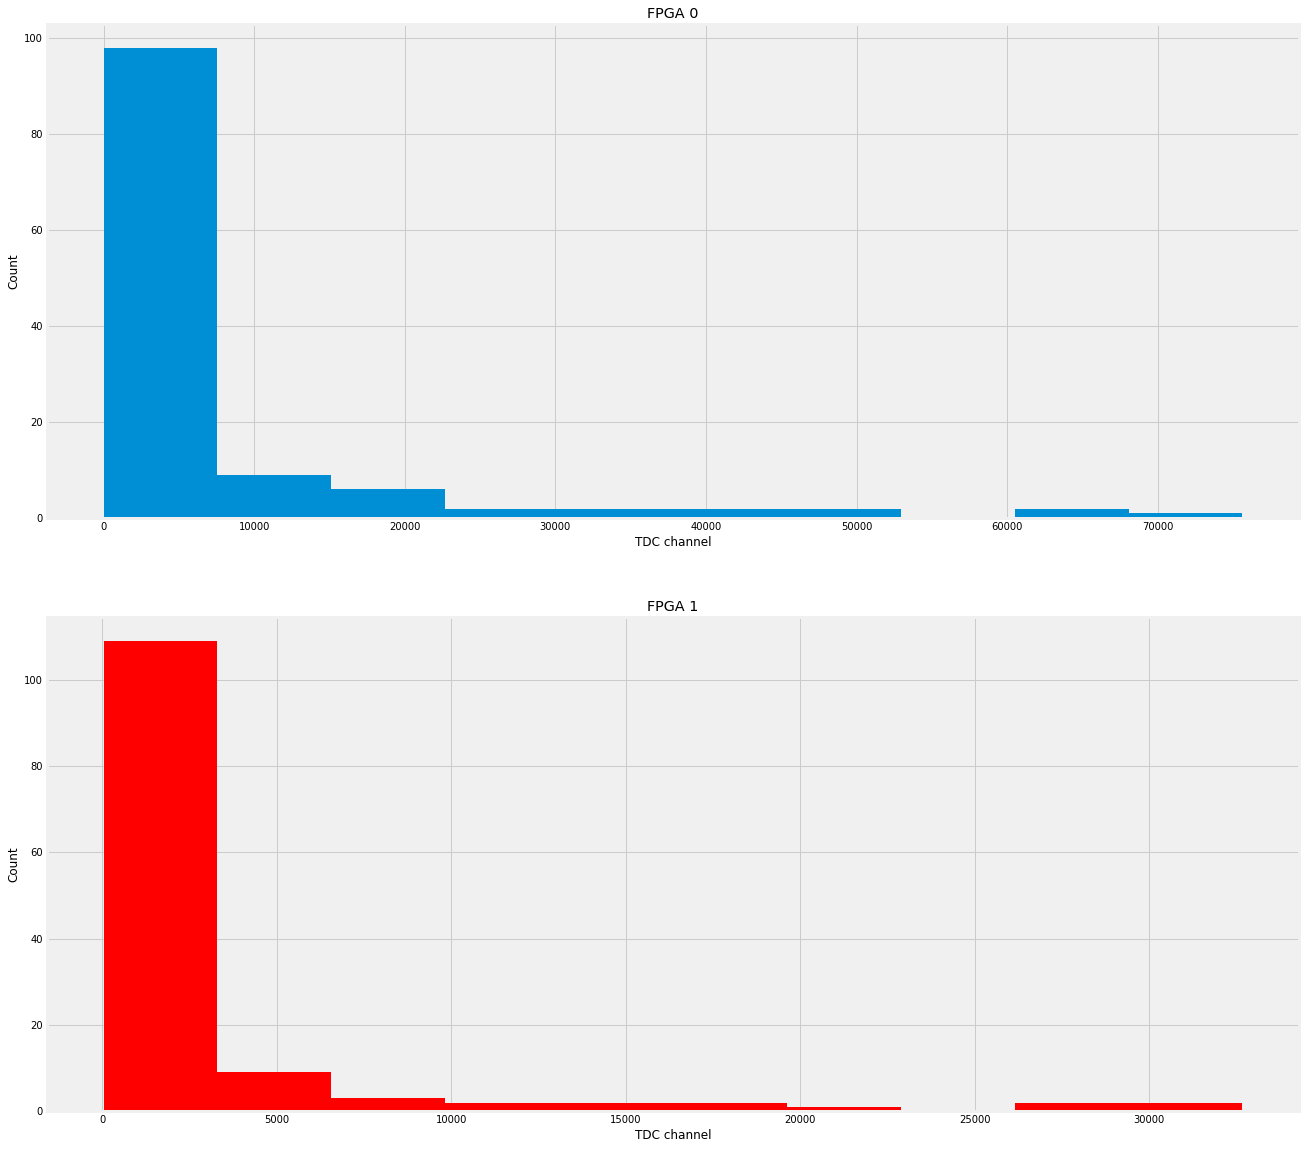

In [15]:
plt.figure(figsize = (20, 20))

plt.subplot(2,1,1)
plt.hist(FPGA_0)
plt.title('FPGA 0')
plt.xlabel('TDC channel')
plt.ylabel('Count')

plt.subplot(2,1,2)
plt.hist(FPGA_1, color='r')
plt.title('FPGA 1')
plt.xlabel('TDC channel')
plt.ylabel('Count')